In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)
from sklearn.ensemble import (
    RandomForestClassifier,
)
from yellowbrick.model_selection import (
    ValidationCurve,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)


X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [2]:
ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [3]:
from sklearn.cluster import KMeans
X_std = preprocessing.StandardScaler().fit_transform(
    X
)
km = KMeans(2, random_state=42)
km.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [4]:
X_km = km.predict(X)
X_km

array([1, 1, 1, ..., 1, 1, 1])

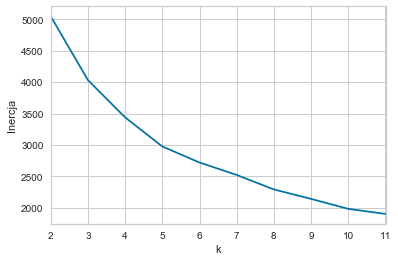

In [17]:
inertias = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(X)
    inertias.append(k2.inertia_)
fig, ax = plt.subplots(figsize=(6, 4))
pd.Series(inertias, index=sizes).plot(ax=ax)
ax.set_xlabel("k")
ax.set_ylabel("Inercja")
# fig.savefig("images/mlpr_1801.png", dpi=300)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:62: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


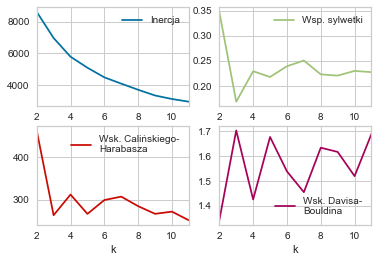

In [24]:
from sklearn import metrics
inertias = []
sils = []
chs = []
dbs = []
sizes = range(2, 12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters=k)
    k2.fit(X_std)
    inertias.append(k2.inertia_)
    sils.append(
        metrics.silhouette_score(X, k2.labels_)
    )
    chs.append(
        metrics.calinski_harabasz_score(
            X, k2.labels_
        )
    )
    dbs.append(
        metrics.davies_bouldin_score(
            X, k2.labels_
        )
    )
fig, ax = plt.subplots(figsize=(6, 4))
(
    pd.DataFrame(
        {
            "Inercja": inertias,
            "Wsp. sylwetki": sils,
            "Wsk. Calińskiego-\nHarabasza": chs,
            "Wsk. Davisa-\nBouldina": dbs,
            "k": sizes,
        }
    )
    .set_index("k")
    .plot(ax=ax, subplots=True, layout=(2, 2))
)
# fig.savefig("images/mlpr_1802.png", dpi=300)

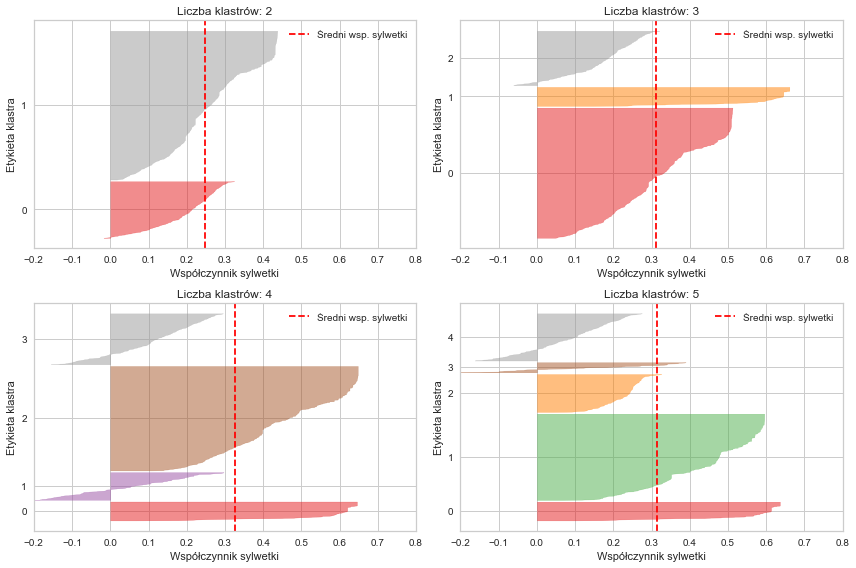

In [47]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
import matplotlib.ticker as ticker
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.reshape(4)
for i, k in enumerate(range(2, 6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
        KMeans(n_clusters=k, random_state=42),
        ax=ax,
    )
    sil.fit(X_std)
    ax.set(title="Liczba klastrów: {}".format(sil.n_clusters_), xlabel="Współczynnik sylwetki", ylabel="Etykieta klastra")
    ax.legend(["Średni wsp. sylwetki"], loc="best")
    ax.set_xlim(-0.2, 0.8)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.set_yticks(sil.y_tick_pos_)
    ax.set_yticklabels(str(idx) for idx in range(sil.n_clusters_))
plt.tight_layout()
# fig.savefig("images/mlpr_1803.png", dpi=300)

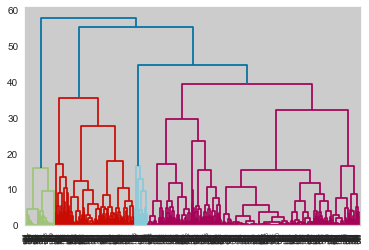

In [48]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6, 4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward")
)
# fig.savefig("images/mlpr_1804.png", dpi=300)

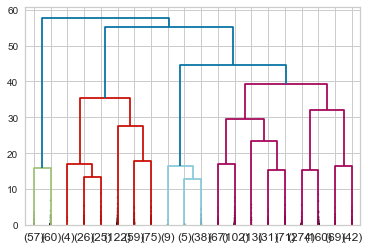

In [49]:
from scipy.cluster import hierarchy
fig, ax = plt.subplots(figsize=(6, 4))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X_std, method="ward"),
    truncate_mode="lastp",
    p=20,
    show_contracted=True,
)
# fig.savefig("images/mlpr_1805.png", dpi=300)

In [10]:
from sklearn.cluster import (
    AgglomerativeClustering,
)
ag = AgglomerativeClustering(
    n_clusters=4,
    affinity="euclidean",
    linkage="ward",
)
ag.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4,
                        pooling_func='deprecated')

In [89]:
km = KMeans(n_clusters=2)
km.fit(X_std)
labels = km.predict(X_std)
res = (
    X.assign(cluster=labels, survived=y)
    .groupby("cluster")
    .agg(["mean", "var"])
    .T
)
res.columns.name = "Klaster"
output = res.rename({"mean": "średnia", "var": "wariancja"}, axis='index')
output

Klaster                      0         1
pclass     średnia    0.527478 -1.420910
           wariancja  0.265532  0.138897
age        średnia   -0.281925  0.922530
           wariancja  0.651165  1.145415
sibsp      średnia   -0.009948 -0.108926
           wariancja  1.164827  0.303463
parch      średnia    0.387949  0.377410
           wariancja  0.830288  0.539488
fare       średnia   -0.349293  0.882876
           wariancja  0.056372  2.223786
sex_male   średnia    0.678647  0.553719
           wariancja  0.218316  0.247797
embarked_Q średnia    0.123679  0.016529
           wariancja  0.108497  0.016301
embarked_S średnia    0.741015  0.586777
           wariancja  0.192115  0.243140
survived   średnia    0.300211  0.595041
           wariancja  0.210307  0.241633

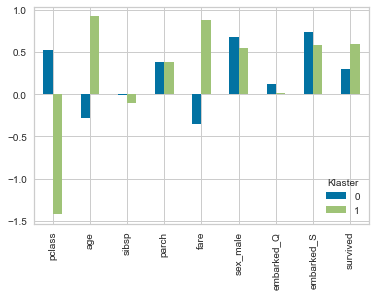

In [97]:
fig, ax = plt.subplots(figsize=(6, 4))
res = (
    X.assign(cluster=labels, survived=y)
    .groupby("cluster")
    .mean()
    .T
)
res.columns.name = "Klaster"
res.plot.bar(ax=ax)
# fig.savefig(
#     "images/mlpr_1806.png",
#     dpi=300,
#     bbox_inches="tight",
# )

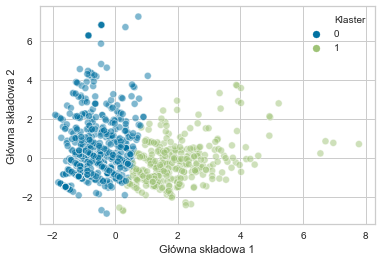

In [127]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler,
)
from yellowbrick.draw import manual_legend

fig, ax = plt.subplots(figsize=(6, 4))
pca = PCA(random_state=42)
X_pca = pca.fit_transform(
    StandardScaler().fit_transform(X)
)
sns.scatterplot(
    "PC1",
    "PC2",
    data=X.assign(
        PC1=X_pca[:, 0],
        PC2=X_pca[:, 1],
        Klaster=labels,
    ),
    hue="Klaster",
    alpha=0.5,
    ax=ax,
)
ax.set(xlabel="Główna składowa 1", ylabel="Główna składowa 2")
# fig.savefig(
#     "images/mlpr_1807.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [132]:
res = (
    X.assign(cluster=labels)
    .groupby("cluster")
    .age.describe()
    .T
)
res.columns.name = "Klaster"
output = res.rename({"count": "liczba", "mean": "średnia", "std": "odch. stand."}, axis='index')
output

Klaster,0,1
liczba,946.000000,363.000000
średnia,-0.281925,0.922530
odch. stand,0.806948,1.070241
min,-2.221251,-2.162722
25%,-0.628414,0.184938
50%,-0.175241,0.809247
75%,0.106899,1.667672
max,3.540599,4.008830


In [134]:
dt = tree.DecisionTreeClassifier()
dt.fit(X, labels)
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda col_val: col_val[1],
    reverse=True,
):
    print(f"{col:10}{val:10.3f}")

pclass         0.904
age            0.080
sex_male       0.013
embarked_S     0.003
fare           0.000
sibsp          0.000
parch          0.000
embarked_Q     0.000


In [138]:
from io import StringIO
import pydotplus
dot_data = StringIO()

tree.export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["0", "1"],
    max_depth=2,
    filled=True,
)
d = dot_data.getvalue().replace("nsamples", "npróbki") \
                       .replace("nvalue", "nwartość") \
                       .replace("nclass", "nklasa") \
                       .replace("True", "tak") \
                       .replace("False", "nie")
g = pydotplus.graph_from_dot_data(d)
# g.write_png("images/mlpr_1808.png")

True